In [73]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [74]:
Lx = 1.0
Ly = 1.0
Nx = 10
Ny = 10

hx = Lx / Nx
hy = Ly / Ny
xx = np.linspace(0, Lx, Nx + 1)
yy = np.linspace(0, Ly, Ny + 1)

alpha = 1 / hx**2
beta = 1 / hy**2
denom = 2 * (alpha + beta)

# Точность и макс. итераций
TOLERANCE = 1e-6
MAX_ITER = 5000

def analytical_solution(x, y):
    return x**2 - y**2

def initialize_grid(Nx, Ny, xx, yy):
    u = np.zeros((Nx + 1, Ny + 1))
    
    # правая граница (x=1)
    for j in range(Ny + 1):
        u[Nx, j] = 1 - yy[j]**2
        
    # верхняя граница (y=1)
    for i in range(Nx + 1):
        u[i, Ny] = 1 - xx[i]**2
    return u

def calc_left_border(border_type: int, j: int, u_prev):
    if border_type == 1:
        return u_prev[1, j]
    if border_type == 2:
        return (4.0 * u_prev[1, j] - u_prev[2, j]) / 3.0
    if border_type == 3:
        if j == 0 or j == Ny:
            return calc_left_border(1, j, u_prev)
        return (alpha*(u_prev[0,j+1] + u_prev[0,j-1]) + 2*beta*u_prev[1,j]) / denom

def calc_bottom_border(border_type: int, i: int, u_prev):
    if border_type == 1:
        return u_prev[i, 1]
    if border_type == 2:
        return (4.0 * u_prev[i, 1] - u_prev[i, 2]) / 3.0
    if border_type == 3:
        if i == 0 or i == Nx:
            return calc_bottom_border(1, i, u_prev)
        return (alpha*(u_prev[i+1, 0] + u_prev[i-1, 0]) + 2*beta*u_prev[i, 1]) / denom

# --- Метод Якоби (Либмана) ---
def solve_libman(u_init, max_iter=MAX_ITER, tol=TOLERANCE):
    u = u_init.copy()
    u_new = u.copy()
    errors = []

    for it in range(max_iter):
        max_diff = 0.0

        for j in range(0, Ny+1):
            # Левая граница
            u_new[0, j] = calc_left_border(3, j, u)
            diff = abs(u_new[0, j] - u[0, j])
            if diff > max_diff: max_diff = diff

            # Правая граница
            u_new[Nx, j] = 1 - yy[j]**2
            diff = abs(u_new[Nx, j] - u[Nx, j])
            if diff > max_diff: max_diff = diff

        for i in range(1, Nx):
            # Нижняя граница (j=0)
            val_bottom = calc_bottom_border(3, i, u)
            diff = abs(val_bottom - u[i,0])
            if diff > max_diff: max_diff = diff
            u_new[i, 0] = val_bottom

            # Внутренние узлы (j от 1 до Ny-1)
            for j in range(1, Ny):
                val = (alpha*(u[i+1,j] + u[i-1,j]) + beta*(u[i,j+1] + u[i,j-1])) / denom
                diff = abs(val - u[i,j])
                if diff > max_diff: max_diff = diff
                u_new[i, j] = val

            # Верхняя граница
            val_top = xx[i]**2 - 1
            diff = abs(val_top - u[i,Ny])
            if diff > max_diff: max_diff = diff
            u_new[i, Ny] = val_top

        u[:] = u_new[:]
        errors.append(max_diff)
        if max_diff < tol:
            print(f"libman: сошлось за {it+1} итераций.")
            return u, errors

    print("Libman: не сошлось.")
    return u, errors

# --- Метод Зейделя ---
def solve_seidel(u_init, max_iter=MAX_ITER, tol=TOLERANCE):
    u = u_init.copy()
    errors = []

    for it in range(max_iter):
        max_diff = 0.0

        for j in range(0, Ny+1):
            # Левая граница
            old_val = u[0, j]
            u[0, j] = calc_left_border(3, j, u)
            diff = abs(u[0, j] - old_val)
            if diff > max_diff: max_diff = diff

            # Правая граница
            old_val = u[Nx, j]
            u[Nx, j] = 1 - yy[j]**2
            diff = abs(u[Nx, j] - old_val)
            if diff > max_diff: max_diff = diff

        for i in range(1, Nx):
            # Нижняя граница
            old_val = u[i,0]
            u[i,0] = calc_bottom_border(3, i, u)
            max_diff = max(max_diff, abs(u[i,0] - old_val))

            # Центр
            for j in range(1, Ny):
                old_val = u[i,j]
                u[i,j] = (alpha*(u[i+1,j] + u[i-1,j]) + beta*(u[i,j+1] + u[i,j-1])) / denom
                max_diff = max(max_diff, abs(u[i,j] - old_val))

            # Верхняя граница
            old_val = u[i,Ny]
            val_top = xx[i]**2 - 1
            u[i,Ny] = val_top
            max_diff = max(max_diff, abs(u[i,Ny] - old_val))

        errors.append(max_diff)
        if max_diff < tol:
            print(f"Seidel: сошлось за {it+1} итераций.")
            return u, errors

    return u, errors

# --- Метод Верхней Релаксации (SOR) ---
def solve_sor(u_init, omega, max_iter=MAX_ITER, tol=TOLERANCE):
    u = u_init.copy()
    errors = []
    
    for it in range(max_iter):
        max_diff = 0.0

        for j in range(0, Ny + 1):
            # Левая граница
            old_val = u[0, j]
            u_new_val = calc_left_border(3, j, u)
            u[0, j] = (1 - omega) * old_val + omega * u_new_val
            max_diff = max(max_diff, abs(u[0, j] - old_val))

            # Правая граница
            old_val = u[Nx, j]
            u_new_val = 1 - yy[j]**2
            u[Nx, j] = (1 - omega) * old_val + omega * u_new_val
            max_diff = max(max_diff, abs(u[Nx, j] - old_val))

        for i in range(1, Nx):
            # Нижняя граница
            old_val = u[i, 0]
            u_seidel = calc_bottom_border(3, i, u)
            u[i, 0] = (1 - omega) * old_val + omega * u_seidel
            max_diff = max(max_diff, abs(u[i, 0] - old_val))

            # Внутренние узлы
            for j in range(1, Ny):
                old_val = u[i, j]
                u_seidel = (alpha*(u[i+1,j] + u[i-1,j]) + beta*(u[i,j+1] + u[i,j-1])) / denom
                u[i, j] = (1 - omega) * old_val + omega * u_seidel
                max_diff = max(max_diff, abs(u[i, j] - old_val))

            # Верхняя граница
            old_val = u[i, Ny]
            u_seidel = xx[i]**2 - 1
            u[i, Ny] = (1 - omega) * old_val + omega * u_seidel
            max_diff = max(max_diff, abs(u[i, Ny] - old_val))

        errors.append(max_diff)
        if max_diff < tol:
            print(f"SOR (w={omega:.2f}): сошлось за {it+1} итераций.")
            return u, errors
    
    return u, errors

# --- ЗАПУСК И АНАЛИЗ ---

# 1. Подготовка
u0 = initialize_grid(Nx, Ny, xx, yy)

# 2. Решение разными методами
u_libman, err_j = solve_libman(u0)
u_seidel, err_s = solve_seidel(u0)

# Оптимальная омега (теоретическая оценка для прямоугольника)
# w_opt = 2 / (1 + sin(pi * h)) - приблизительно

w_opt = 1.5 # Можно подобрать вручную или вычислить точно

u_sor, err_sor = solve_sor(u0, omega=w_opt)

# 3. Вычисление точного решения для сравнения
u_exact = np.zeros_like(u0)
for i in range(Nx + 1):
    for j in range(Ny + 1):
        u_exact[i, j] = analytical_solution(xx[i], yy[j])

# 4. Оценка глобальной погрешности
error_grid = np.abs(u_sor - u_exact)
max_error = np.max(error_grid)
# print(f"\nМаксимальная погрешность (SOR): {max_error:.6f}")


libman: сошлось за 651 итераций.
Seidel: сошлось за 262 итераций.
SOR (w=1.50): сошлось за 116 итераций.


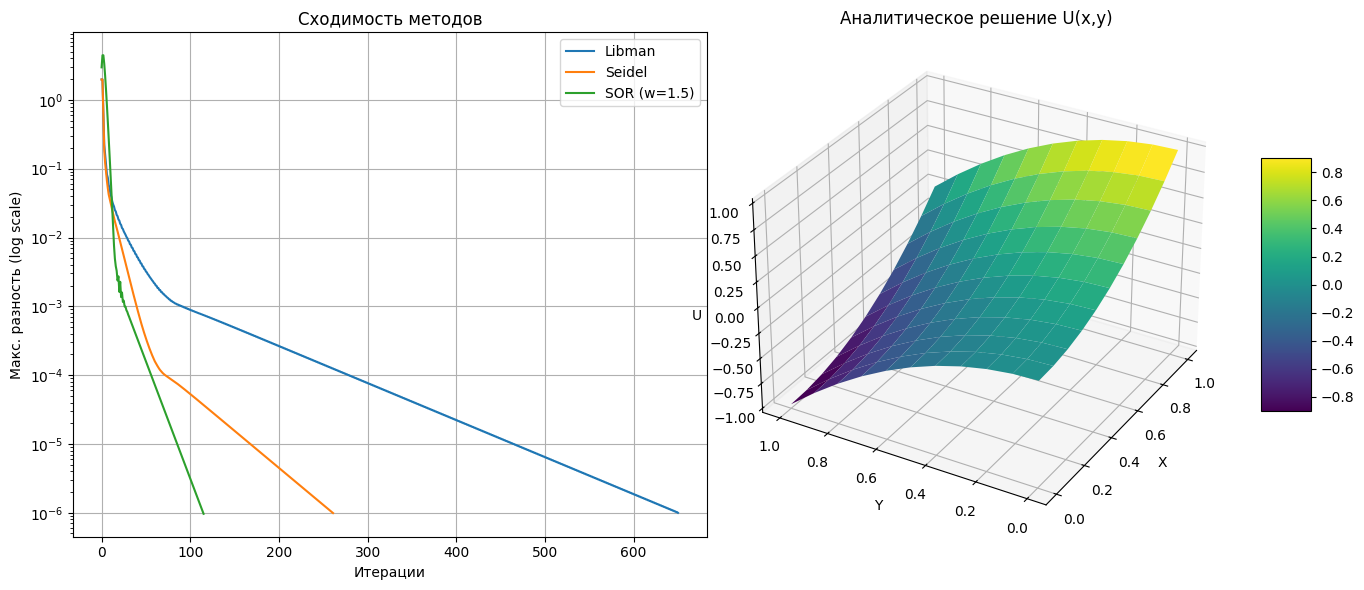

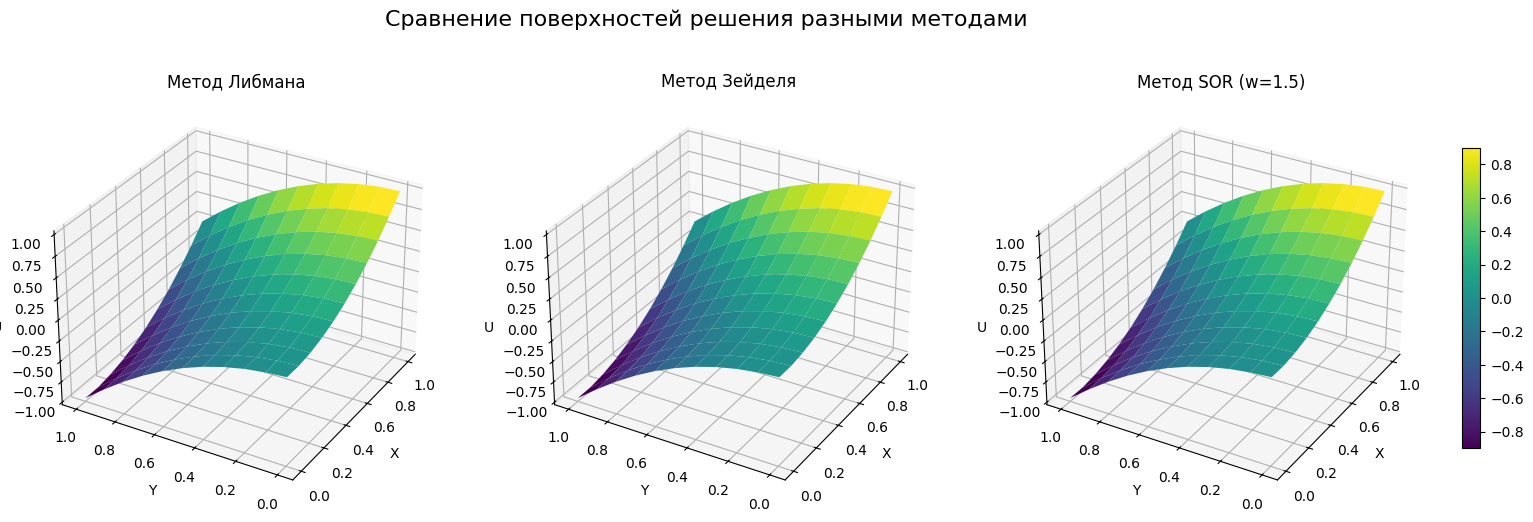

In [75]:
# --- ВИЗУАЛИЗАЦИЯ ---
fig = plt.figure(figsize=(14, 6))

# График 1: Сравнение скорости сходимости
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(err_j, label='Libman')
ax1.plot(err_s, label='Seidel')
ax1.plot(err_sor, label=f'SOR (w={w_opt})')
ax1.set_yscale('log')
ax1.set_xlabel('Итерации')
ax1.set_ylabel('Макс. разность (log scale)')
ax1.set_title('Сходимость методов')
ax1.legend()
ax1.grid(True)

# График 2: Поверхность численного решения
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
X, Y = np.meshgrid(yy, xx) 

Y_plt, X_plt = np.meshgrid(yy, xx)

surf = ax2.plot_surface(X_plt, Y_plt, u_exact, cmap='viridis', edgecolor='none')
ax2.set_title('Аналитическое решение U(x,y)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('U')
ax2.view_init(elev=30, azim=-150)
fig.colorbar(surf, ax=ax2, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()

# --- ВИЗУАЛИЗАЦИЯ (3 графика рядом) ---
fig2 = plt.figure(figsize=(18, 6))


Y_plt, X_plt = np.meshgrid(yy, xx)

# Список решений и названий для цикла
methods_data = [
    (u_libman, 'Метод Либмана'),
    (u_seidel, 'Метод Зейделя'),
    (u_sor, f'Метод SOR (w={w_opt})')
]

for idx, (u_data, title) in enumerate(methods_data):
    # Добавляем subplot: 2 строка, 3 столбца, номер графика idx+1
    ax = fig2.add_subplot(1, 3, idx + 1, projection='3d')
    
    # Построение поверхности
    surf = ax.plot_surface(X_plt, Y_plt, u_data, cmap='viridis', edgecolor='none')
    
    # Оформление
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    
    # Настройка угла обзора (можно поменять, чтобы лучше видеть изгиб)
    ax.view_init(elev=30, azim=-150)

# Добавляем общую цветовую шкалу справа
fig2.subplots_adjust(right=0.9)
cbar_ax = fig2.add_axes([0.92, 0.25, 0.01, 0.5]) # [left, bottom, width, height]
fig2.colorbar(surf, cax=cbar_ax)

plt.suptitle("Сравнение поверхностей решения разными методами", fontsize=16)
plt.show()

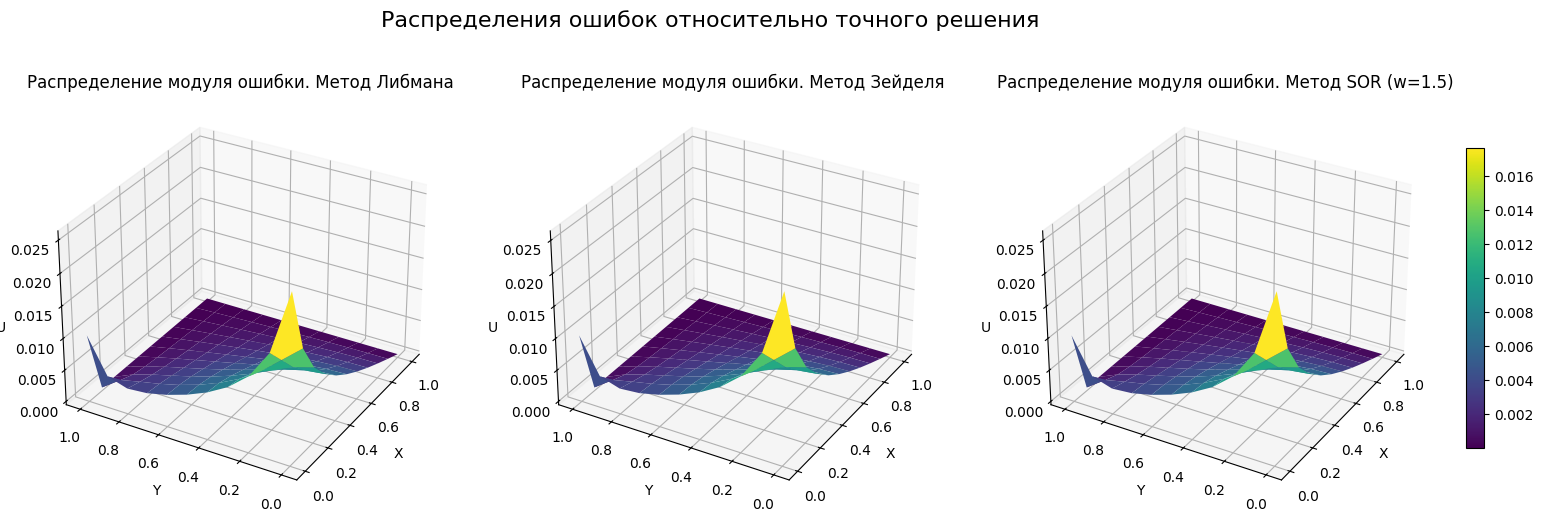

In [76]:
# --- ВИЗУАЛИЗАЦИЯ ОШИБОК ---
fig3 = plt.figure(figsize=(18, 6))


Y_plt, X_plt = np.meshgrid(yy, xx)


errors_data = [
    (np.abs(u_libman - u_exact), 'Распределение модуля ошибки. Метод Либмана'),
    (np.abs(u_seidel - u_exact), 'Распределение модуля ошибки. Метод Зейделя'),
    (np.abs(u_sor - u_exact), f'Распределение модуля ошибки. Метод SOR (w={w_opt})')
]

for idx, (u_data, title) in enumerate(errors_data):
    # Добавляем subplot: 2 строка, 3 столбца, номер графика idxЭ+1
    ax = fig3.add_subplot(1, 3, idx + 1, projection='3d')
    
    surf = ax.plot_surface(X_plt, Y_plt, u_data, cmap='viridis', edgecolor='none')
    
    # Оформление
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('U')
    
    ax.view_init(elev=30, azim=-150)

fig3.subplots_adjust(right=0.9)
cbar_ax = fig3.add_axes([0.92, 0.25, 0.01, 0.5]) # [left, bottom, width, height]
fig3.colorbar(surf, cax=cbar_ax)

plt.suptitle("Распределения ошибок относительно точного решения", fontsize=16)
plt.show()

Строим 6 графиков срезов...


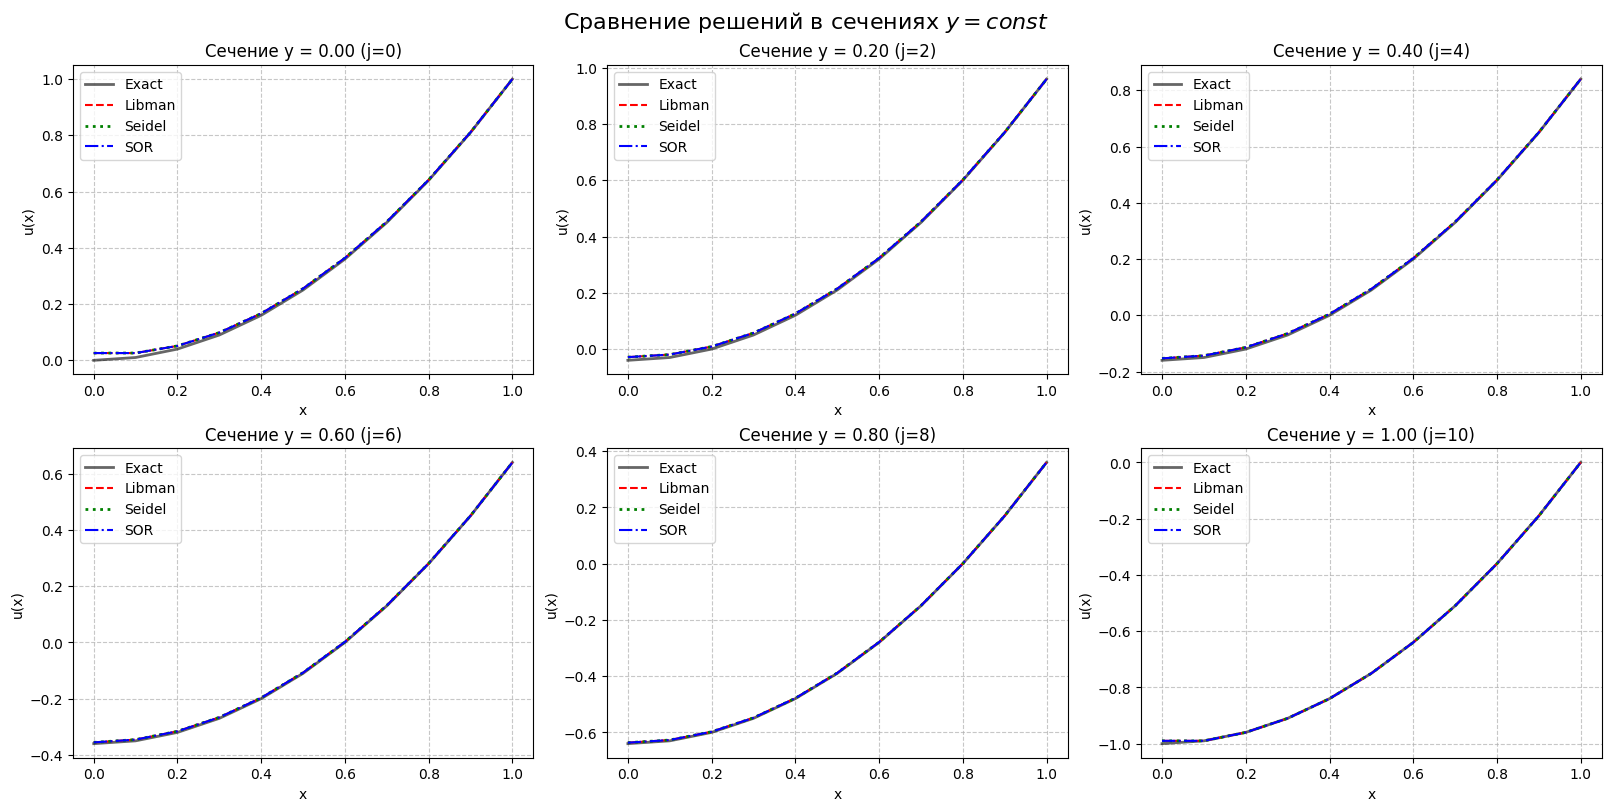

In [77]:
# --- ВИЗУАЛИЗАЦИЯ СРЕЗОВ ПО Y ---

# Настройка отображения
# Если разбиение Ny очень большое (например, 100), рисовать все графики не стоит.
# step_plot позволяет пропускать некоторые срезы (1 = рисовать все, 2 = через один и т.д.)
step_plot = 2
indices_to_plot = range(0, Ny + 1, step_plot)
num_plots = len(indices_to_plot)

cols = 3 
rows = math.ceil(num_plots / cols)

# Создаем "отдельное полотно" большого размера
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), constrained_layout=True)
axes_flat = axes.flatten() # Превращаем матрицу осей в плоский список для удобства

print(f"Строим {num_plots} графиков срезов...")

for idx, j in enumerate(indices_to_plot):
    ax = axes_flat[idx]
    y_val = yy[j]
    
    # 1. Данные срезов (берем все x для фиксированного j)
    slice_libman = u_libman[:, j]
    slice_seidel = u_seidel[:, j]
    slice_sor = u_sor[:, j]
    
    # 2. Точное решение для этого y (векторизованно по x)
    # analytical_solution умеет работать с массивами numpy
    slice_exact = analytical_solution(xx, y_val)
    
    # 3. Построение графиков
    # Рисуем точное решение сплошной линией
    ax.plot(xx, slice_exact, 'k-', linewidth=2, alpha=0.6, label='Exact')
    
    # Рисуем численные решения разными стилями пунктира/точек
    ax.plot(xx, slice_libman, 'r--', linewidth=1.5, label='Libman')
    ax.plot(xx, slice_seidel, 'g:', linewidth=2, label='Seidel')
    ax.plot(xx, slice_sor, 'b-.', linewidth=1.5, label='SOR')
    
    # Оформление
    ax.set_title(f"Сечение y = {y_val:.2f} (j={j})")
    ax.set_xlabel("x")
    ax.set_ylabel("u(x)")
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Легенду добавляем только на первый график, чтобы не загромождать остальные
    if idx == 0:
        ax.legend()

# Удаляем пустые оси, если количество графиков не кратно cols
for k in range(idx + 1, len(axes_flat)):
    axes_flat[k].axis('off')

plt.suptitle("Сравнение решений в сечениях $y = const$", fontsize=16)
plt.show()